In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import lagrange, CubicSpline
import zipfile
import io
import requests

In [34]:
# Step 1: Load Real Air Quality Data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip"
response = requests.get(url)
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    file_name = [name for name in z.namelist() if name.endswith('.csv')][0]
    with z.open(file_name) as f:
        data = pd.read_csv(f, sep=';', decimal=',', na_values=-200)

# Combine Date and Time columns into a single Datetime column
data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%d/%m/%Y %H.%M.%S', errors='coerce')

# Extract relevant columns
columns_of_interest = ['Datetime', 'CO(GT)', 'NO2(GT)', 'PT08.S5(O3)']
data = data[columns_of_interest]
data.columns = ['Datetime', 'CO', 'NO2', 'O3']
data = data.dropna().reset_index(drop=True)

# Subset the data for relevant metrics
subset_data = data.iloc[:24]
time_points = np.arange(0, len(subset_data))
air_quality = subset_data['CO'].values

# Separate the 'CO', 'NO2', and 'O3' columns into their own arrays
co_values = subset_data['CO'].values
no2_values = subset_data['NO2'].values
o3_values = subset_data['O3'].values

# Create an x-axis time array from 0 to N-1 (for plotting purposes)
time_axis = np.arange(0, len(subset_data))

First few rows of the dataset:
             Datetime   CO    NO2      O3
0 2004-03-10 18:00:00  2.6  113.0  1268.0
1 2004-03-10 19:00:00  2.0   92.0   972.0
2 2004-03-10 20:00:00  2.2  114.0  1074.0
3 2004-03-10 21:00:00  2.2  122.0  1203.0
4 2004-03-10 22:00:00  1.6  116.0  1110.0


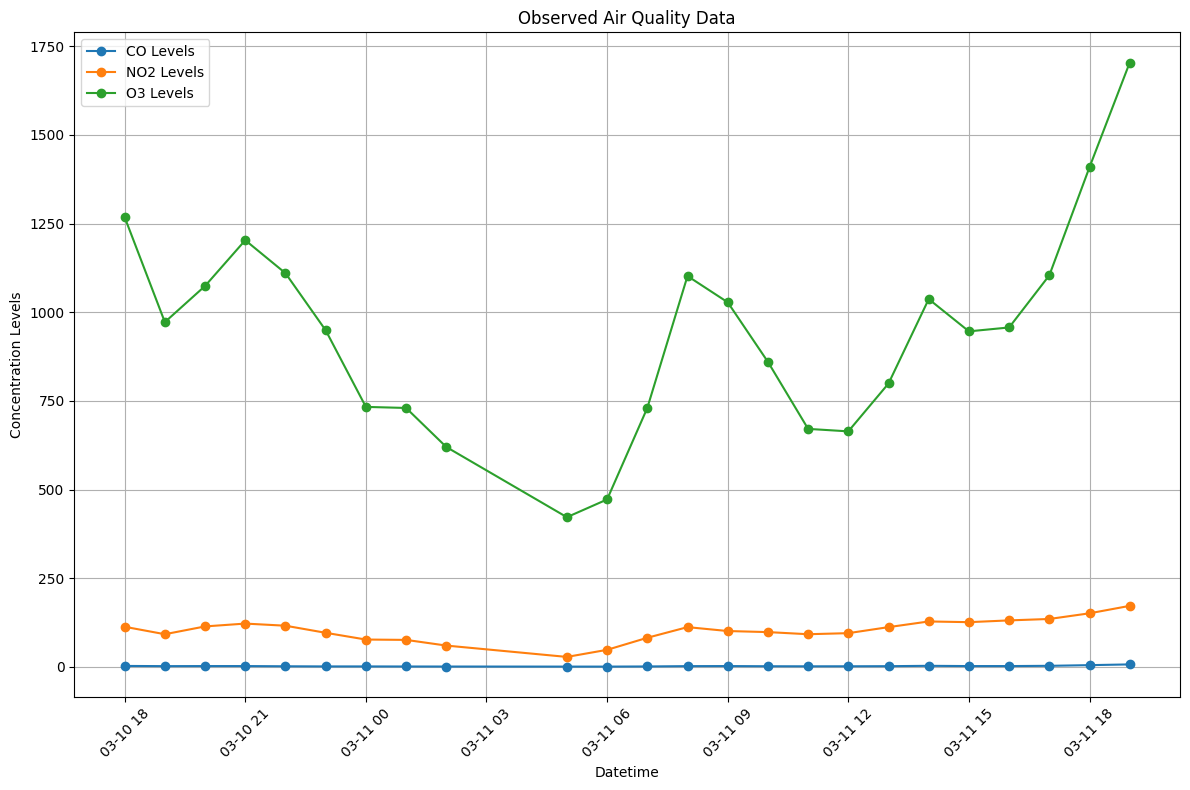

First few rows of the missing dataset:
             Datetime   CO    NO2      O3
0 2004-03-10 18:00:00  NaN    NaN  1268.0
1 2004-03-10 19:00:00  2.0    NaN   972.0
2 2004-03-10 20:00:00  2.2  114.0  1074.0
3 2004-03-10 21:00:00  2.2  122.0  1203.0
4 2004-03-10 22:00:00  1.6  116.0     NaN


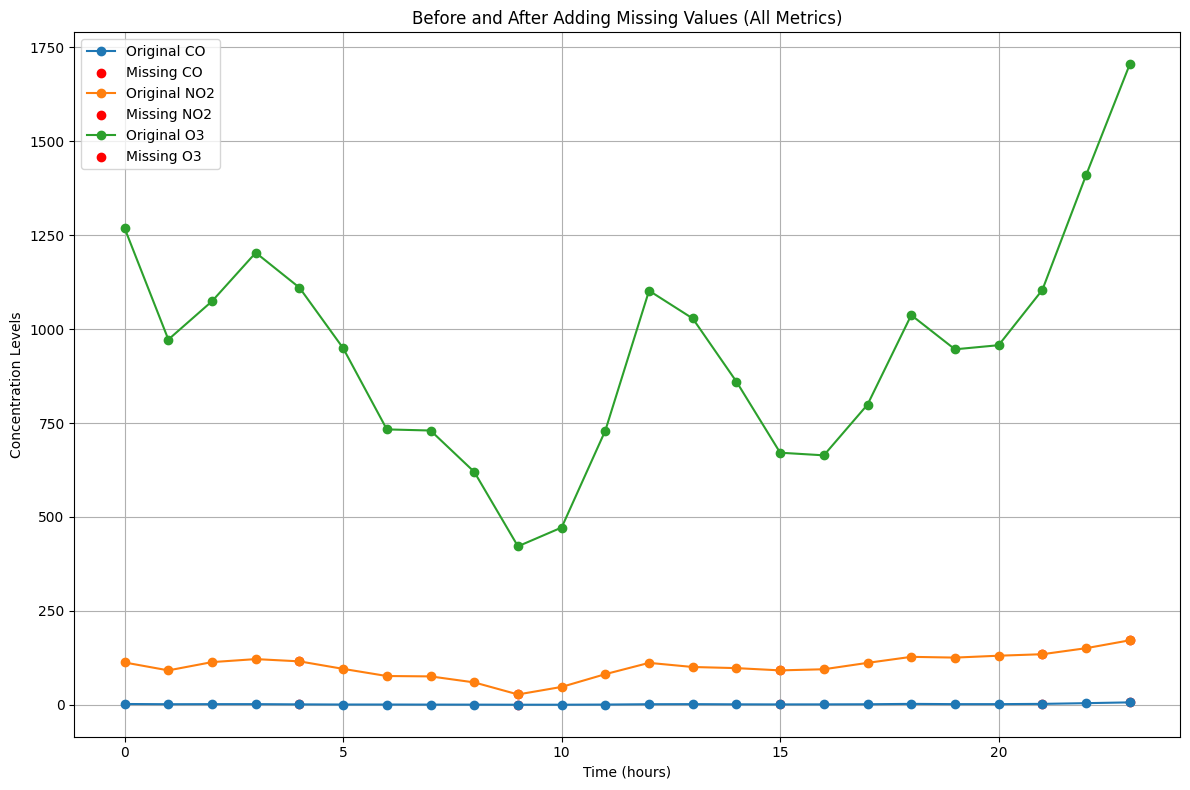

In [35]:
# Step 1.5: Inspect and Plot the Data
print("First few rows of the dataset:")
print(subset_data.head())

plt.figure(figsize=(12, 8))
for column in ['CO', 'NO2', 'O3']:
    plt.plot(subset_data['Datetime'], subset_data[column], marker='o', label=f'{column} Levels')

plt.xlabel('Datetime')
plt.ylabel('Concentration Levels')
plt.title('Observed Air Quality Data')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Introduce missing values
np.random.seed(42)
missing_data = subset_data.copy()
for col in ['CO', 'NO2', 'O3']:
    missing_indices = np.random.choice(len(time_points), size=5, replace=False)
    missing_data.loc[missing_indices, col] = np.nan

print("First few rows of the missing dataset:")
print(missing_data.head())

# Visualize Before and After Adding Missing Values
plt.figure(figsize=(12, 8))
for column in ['CO', 'NO2', 'O3']:
    plt.plot(time_points, subset_data[column], marker='o', label=f'Original {column}')
    plt.scatter(time_points[missing_indices], missing_data.loc[missing_indices, column], color='r', label=f'Missing {column}')

plt.xlabel('Time (hours)')
plt.ylabel('Concentration Levels')
plt.title('Before and After Adding Missing Values (All Metrics)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
# Step 2: Define Interpolation Functions
def lagrange_interpolation(x, y, missing):
    interpolated_values = []
    for m in missing:
        valid_indices = ~np.isnan(y)
        polynomial = lagrange(x[valid_indices], y[valid_indices])
        interpolated_values.append(polynomial(x[m]))
    return np.array(interpolated_values)

def newtons_divided_differences(x, y, missing):
    def divided_differences(x, y):
        n = len(y)
        table = np.zeros((n, n))
        table[:, 0] = y
        for j in range(1, n):
            for i in range(n - j):
                table[i, j] = (table[i + 1, j - 1] - table[i, j - 1]) / (x[i + j] - x[i])
        return table[0, :]

    valid_indices = ~np.isnan(y)
    x_valid = x[valid_indices]
    y_valid = y[valid_indices]
    coefficients = divided_differences(x_valid, y_valid)

    def newton_polynomial(x_eval):
        result = coefficients[-1]
        for coeff in coefficients[-2::-1]:
            result = result * (x_eval - x_valid[0]) + coeff
        return result

    interpolated_values = [newton_polynomial(x[m]) for m in missing]
    return np.array(interpolated_values)

In [36]:
# Step 3: Apply Interpolation Methods
valid_indices = ~np.isnan(air_quality)
x_known = time_points[valid_indices]
y_known = air_quality[valid_indices]

# Lagrange Interpolation
lagrange_values = lagrange_interpolation(time_points, air_quality, missing_indices)
co_lagrange_values = lagrange_interpolation(time_axis, co_values, missing_indices)
no2_lagrange_values = lagrange_interpolation(time_axis, no2_values, missing_indices)
o3_lagrange_values = lagrange_interpolation(time_axis, o3_values, missing_indices)

# Newton's Divided Differences
newton_values = newtons_divided_differences(time_points, air_quality, missing_indices)
co_newton_values = newtons_divided_differences(time_axis, co_values, missing_indices)
no2_newton_values = newtons_divided_differences(time_axis, no2_values, missing_indices)
o3_newton_values = newtons_divided_differences(time_axis, o3_values, missing_indices)

# Cubic Splines
cs = CubicSpline(x_known, y_known)
cubic_spline_values = cs(time_points[missing_indices])
co_cs = CubicSpline(time_axis, co_values)
co_cubic_spline_values = co_cs(time_points[missing_indices])
no2_cs = CubicSpline(time_axis, no2_values)
no2_cubic_spline_values = no2_cs(time_points[missing_indices])
o3_cs = CubicSpline(time_axis, o3_values)
o3_cubic_spline_values = o3_cs(time_points[missing_indices])

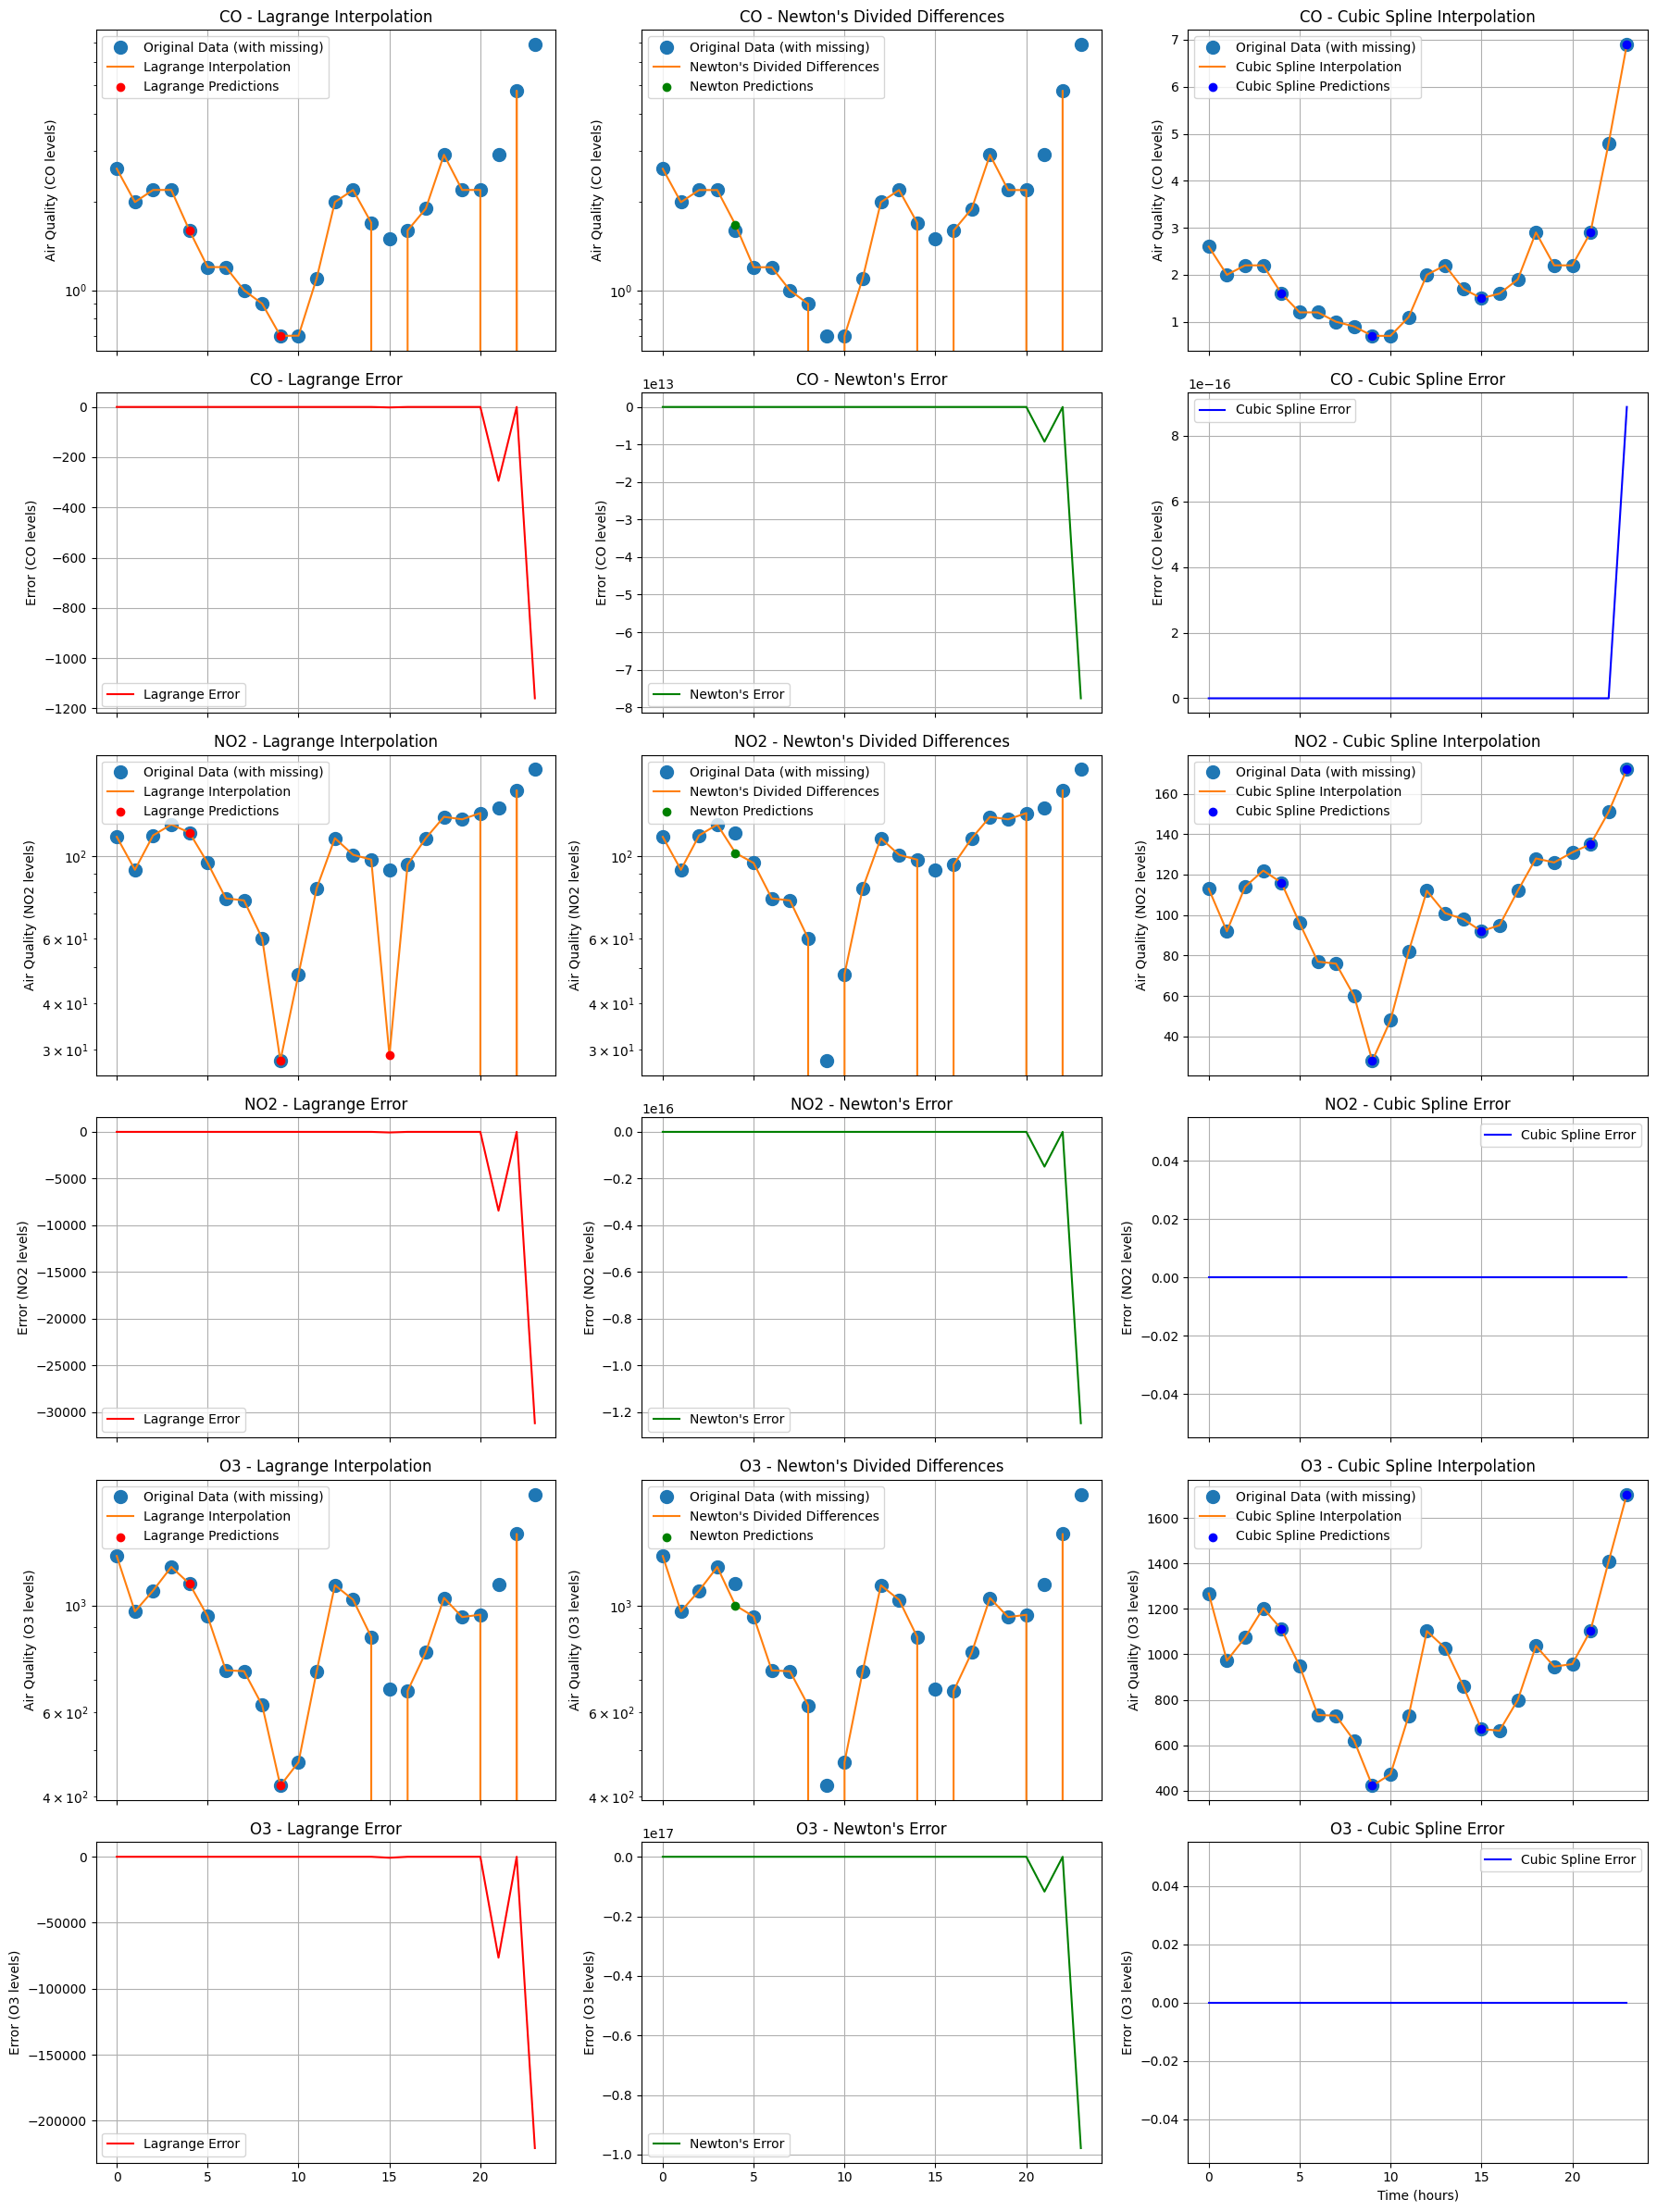

In [40]:
import matplotlib.pyplot as plt

# Step 4: Fill Missing Values, Calculate Errors, and Visualization for CO, NO2, O3
filled_lagrange_co = air_quality.copy()
filled_lagrange_co[missing_indices] = lagrange_values

filled_newton_co = air_quality.copy()
filled_newton_co[missing_indices] = newton_values

filled_cubic_spline_co = air_quality.copy()
filled_cubic_spline_co[missing_indices] = cubic_spline_values

# Errors for CO
error_lagrange_co = filled_lagrange_co - air_quality
error_newton_co = filled_newton_co - air_quality
error_cubic_spline_co = filled_cubic_spline_co - air_quality

# Similar for NO2
filled_lagrange_no2 = no2_values.copy()
filled_lagrange_no2[missing_indices] = no2_lagrange_values

filled_newton_no2 = no2_values.copy()
filled_newton_no2[missing_indices] = no2_newton_values

filled_cubic_spline_no2 = no2_values.copy()
filled_cubic_spline_no2[missing_indices] = no2_cubic_spline_values

# Errors for NO2
error_lagrange_no2 = filled_lagrange_no2 - no2_values
error_newton_no2 = filled_newton_no2 - no2_values
error_cubic_spline_no2 = filled_cubic_spline_no2 - no2_values

# Similar for O3
filled_lagrange_o3 = o3_values.copy()
filled_lagrange_o3[missing_indices] = o3_lagrange_values

filled_newton_o3 = o3_values.copy()
filled_newton_o3[missing_indices] = o3_newton_values

filled_cubic_spline_o3 = o3_values.copy()
filled_cubic_spline_o3[missing_indices] = o3_cubic_spline_values

# Errors for O3
error_lagrange_o3 = filled_lagrange_o3 - o3_values
error_newton_o3 = filled_newton_o3 - o3_values
error_cubic_spline_o3 = filled_cubic_spline_o3 - o3_values

# Create subplots for CO, NO2, and O3 interpolation methods and errors
fig, axs = plt.subplots(6, 3, figsize=(18, 24), sharex=True)

# CO Interpolation Plots
axs[0, 0].plot(time_points, air_quality, 'o', label='Original Data (with missing)', markersize=10)
axs[0, 0].plot(time_points, filled_lagrange_co, label='Lagrange Interpolation')
axs[0, 0].scatter(time_points[missing_indices], lagrange_values, color='r', label='Lagrange Predictions', zorder=5)
axs[0, 0].set_title('CO - Lagrange Interpolation')
axs[0, 0].set_ylabel('Air Quality (CO levels)')
axs[0, 0].set_yscale('log')  # Set y-scale to logarithmic for Lagrange
axs[0, 0].legend()
axs[0, 0].grid()

axs[0, 1].plot(time_points, air_quality, 'o', label='Original Data (with missing)', markersize=10)
axs[0, 1].plot(time_points, filled_newton_co, label="Newton's Divided Differences")
axs[0, 1].scatter(time_points[missing_indices], newton_values, color='g', label='Newton Predictions', zorder=5)
axs[0, 1].set_title("CO - Newton's Divided Differences")
axs[0, 1].set_ylabel('Air Quality (CO levels)')
axs[0, 1].set_yscale('log')  # Set y-scale to logarithmic for Newton's method
axs[0, 1].legend()
axs[0, 1].grid()

axs[0, 2].plot(time_points, air_quality, 'o', label='Original Data (with missing)', markersize=10)
axs[0, 2].plot(time_points, filled_cubic_spline_co, label='Cubic Spline Interpolation')
axs[0, 2].scatter(time_points[missing_indices], cubic_spline_values, color='b', label='Cubic Spline Predictions', zorder=5)
axs[0, 2].set_title('CO - Cubic Spline Interpolation')
axs[0, 2].set_ylabel('Air Quality (CO levels)')
axs[0, 2].legend()
axs[0, 2].grid()

# CO Error Plots
axs[1, 0].plot(time_points, error_lagrange_co, label='Lagrange Error', color='r')
axs[1, 0].set_title('CO - Lagrange Error')
axs[1, 0].set_ylabel('Error (CO levels)')
axs[1, 0].legend()
axs[1, 0].grid()

axs[1, 1].plot(time_points, error_newton_co, label="Newton's Error", color='g')
axs[1, 1].set_title("CO - Newton's Error")
axs[1, 1].set_ylabel('Error (CO levels)')
axs[1, 1].legend()
axs[1, 1].grid()

axs[1, 2].plot(time_points, error_cubic_spline_co, label='Cubic Spline Error', color='b')
axs[1, 2].set_title('CO - Cubic Spline Error')
axs[1, 2].set_ylabel('Error (CO levels)')
axs[1, 2].legend()
axs[1, 2].grid()

# NO2 Interpolation Plots
axs[2, 0].plot(time_points, no2_values, 'o', label='Original Data (with missing)', markersize=10)
axs[2, 0].plot(time_points, filled_lagrange_no2, label='Lagrange Interpolation')
axs[2, 0].scatter(time_points[missing_indices], no2_lagrange_values, color='r', label='Lagrange Predictions', zorder=5)
axs[2, 0].set_title('NO2 - Lagrange Interpolation')
axs[2, 0].set_ylabel('Air Quality (NO2 levels)')
axs[2, 0].set_yscale('log')  # Set y-scale to logarithmic for Lagrange
axs[2, 0].legend()
axs[2, 0].grid()

axs[2, 1].plot(time_points, no2_values, 'o', label='Original Data (with missing)', markersize=10)
axs[2, 1].plot(time_points, filled_newton_no2, label="Newton's Divided Differences")
axs[2, 1].scatter(time_points[missing_indices], no2_newton_values, color='g', label='Newton Predictions', zorder=5)
axs[2, 1].set_title("NO2 - Newton's Divided Differences")
axs[2, 1].set_ylabel('Air Quality (NO2 levels)')
axs[2, 1].set_yscale('log')  # Set y-scale to logarithmic for Newton's method
axs[2, 1].legend()
axs[2, 1].grid()

axs[2, 2].plot(time_points, no2_values, 'o', label='Original Data (with missing)', markersize=10)
axs[2, 2].plot(time_points, filled_cubic_spline_no2, label='Cubic Spline Interpolation')
axs[2, 2].scatter(time_points[missing_indices], no2_cubic_spline_values, color='b', label='Cubic Spline Predictions', zorder=5)
axs[2, 2].set_title('NO2 - Cubic Spline Interpolation')
axs[2, 2].set_ylabel('Air Quality (NO2 levels)')
axs[2, 2].legend()
axs[2, 2].grid()

# NO2 Error Plots
axs[3, 0].plot(time_points, error_lagrange_no2, label='Lagrange Error', color='r')
axs[3, 0].set_title('NO2 - Lagrange Error')
axs[3, 0].set_ylabel('Error (NO2 levels)')
axs[3, 0].legend()
axs[3, 0].grid()

axs[3, 1].plot(time_points, error_newton_no2, label="Newton's Error", color='g')
axs[3, 1].set_title("NO2 - Newton's Error")
axs[3, 1].set_ylabel('Error (NO2 levels)')
axs[3, 1].legend()
axs[3, 1].grid()

axs[3, 2].plot(time_points, error_cubic_spline_no2, label='Cubic Spline Error', color='b')
axs[3, 2].set_title('NO2 - Cubic Spline Error')
axs[3, 2].set_ylabel('Error (NO2 levels)')
axs[3, 2].legend()
axs[3, 2].grid()

# O3 Interpolation Plots
axs[4, 0].plot(time_points, o3_values, 'o', label='Original Data (with missing)', markersize=10)
axs[4, 0].plot(time_points, filled_lagrange_o3, label='Lagrange Interpolation')
axs[4, 0].scatter(time_points[missing_indices], o3_lagrange_values, color='r', label='Lagrange Predictions', zorder=5)
axs[4, 0].set_title('O3 - Lagrange Interpolation')
axs[4, 0].set_ylabel('Air Quality (O3 levels)')
axs[4, 0].set_yscale('log')  # Set y-scale to logarithmic for Lagrange
axs[4, 0].legend()
axs[4, 0].grid()

axs[4, 1].plot(time_points, o3_values, 'o', label='Original Data (with missing)', markersize=10)
axs[4, 1].plot(time_points, filled_newton_o3, label="Newton's Divided Differences")
axs[4, 1].scatter(time_points[missing_indices], o3_newton_values, color='g', label='Newton Predictions', zorder=5)
axs[4, 1].set_title("O3 - Newton's Divided Differences")
axs[4, 1].set_ylabel('Air Quality (O3 levels)')
axs[4, 1].set_yscale('log')  # Set y-scale to logarithmic for Newton's method
axs[4, 1].legend()
axs[4, 1].grid()

axs[4, 2].plot(time_points, o3_values, 'o', label='Original Data (with missing)', markersize=10)
axs[4, 2].plot(time_points, filled_cubic_spline_o3, label='Cubic Spline Interpolation')
axs[4, 2].scatter(time_points[missing_indices], o3_cubic_spline_values, color='b', label='Cubic Spline Predictions', zorder=5)
axs[4, 2].set_title('O3 - Cubic Spline Interpolation')
axs[4, 2].set_ylabel('Air Quality (O3 levels)')
axs[4, 2].legend()
axs[4, 2].grid()

# O3 Error Plots
axs[5, 0].plot(time_points, error_lagrange_o3, label='Lagrange Error', color='r')
axs[5, 0].set_title('O3 - Lagrange Error')
axs[5, 0].set_ylabel('Error (O3 levels)')
axs[5, 0].legend()
axs[5, 0].grid()

axs[5, 1].plot(time_points, error_newton_o3, label="Newton's Error", color='g')
axs[5, 1].set_title("O3 - Newton's Error")
axs[5, 1].set_ylabel('Error (O3 levels)')
axs[5, 1].legend()
axs[5, 1].grid()

axs[5, 2].plot(time_points, error_cubic_spline_o3, label='Cubic Spline Error', color='b')
axs[5, 2].set_title('O3 - Cubic Spline Error')
axs[5, 2].set_xlabel('Time (hours)')
axs[5, 2].set_ylabel('Error (O3 levels)')
axs[5, 2].legend()
axs[5, 2].grid()

plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()


In [ ]:
# Step 5: Error Analysis (assuming synthetic true values for demonstration)
true_values = air_quality[~np.isnan(air_quality)]
lagrange_error = np.abs(lagrange_values - air_quality[missing_indices])
newton_error = np.abs(newton_values - air_quality[missing_indices])
cubic_spline_error = np.abs(cubic_spline_values - air_quality[missing_indices])

print("Error Analysis:")
print("Lagrange Mean Absolute Error:", np.nanmean(lagrange_error))
print("Newton Mean Absolute Error:", np.nanmean(newton_error))
print("Cubic Spline Mean Absolute Error:", np.nanmean(cubic_spline_error))


Error Analysis:
Lagrange Mean Absolute Error: nan
Newton Mean Absolute Error: nan
Cubic Spline Mean Absolute Error: nan


<ipython-input-10-2cf9b1912843>:8: RuntimeWarning: Mean of empty slice
  print("Lagrange Mean Absolute Error:", np.nanmean(lagrange_error))
<ipython-input-10-2cf9b1912843>:9: RuntimeWarning: Mean of empty slice
  print("Newton Mean Absolute Error:", np.nanmean(newton_error))
<ipython-input-10-2cf9b1912843>:10: RuntimeWarning: Mean of empty slice
  print("Cubic Spline Mean Absolute Error:", np.nanmean(cubic_spline_error))
